<a href="https://colab.research.google.com/github/harshy02/Crowd-Check/blob/master/social_distancing_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#colab has CUDA 10.1
#install dependencies:
!pip install cython pyyaml==5.1 pycocotools>=2.0.1

# install detectron2 for torch 1.6:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

In [2]:
# basic setupa:
# Import and setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import required python libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer


In [5]:
# Read a video
# Save frames to a folder
%%time
!rm -r frames/*       # remove
!mkdir frames/        # make directory

# path to video
video = "/content/drive/My Drive/Crowd Check/street.mp4"

#capture video
cap = cv2.VideoCapture(video)
cnt = 0

# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret, first_frame = cap.read()

# Read until video is finished
while(cap.isOpened()):
    
  # Capture video frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    # Save each frame to a folder        
    cv2.imwrite('frames/' + str(cnt) + '.png', frame)       # Save frames in .png
    cnt += 1
    if(cnt==750):
      break

  # Break loop
  else: 
    break

rm: cannot remove 'frames/*': No such file or directory
CPU times: user 1min 29s, sys: 2.38 s, total: 1min 32s
Wall time: 1min 21s


In [6]:
# Check frame rate of input video
FPS = cap.get(cv2.CAP_PROP_FPS)
print(FPS)

25.0


In [7]:
# create a detectron2 config and a detectron2 DefaultPredictor to run inference 
cfg = get_cfg()

# add project-specific config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model

# Find a pre-trained model from detectron2's model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

WARNING [10/03 09:29:57 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


model_final_f97cb7.pkl: 136MB [00:05, 24.1MB/s]                           


In [9]:
#read an image in frames folder
img = cv2.imread("/content/frames/100.png")

#pass into the model for predictions
outputs = predictor(img)

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:111: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  filter_inds = filter_mask.nonzero()


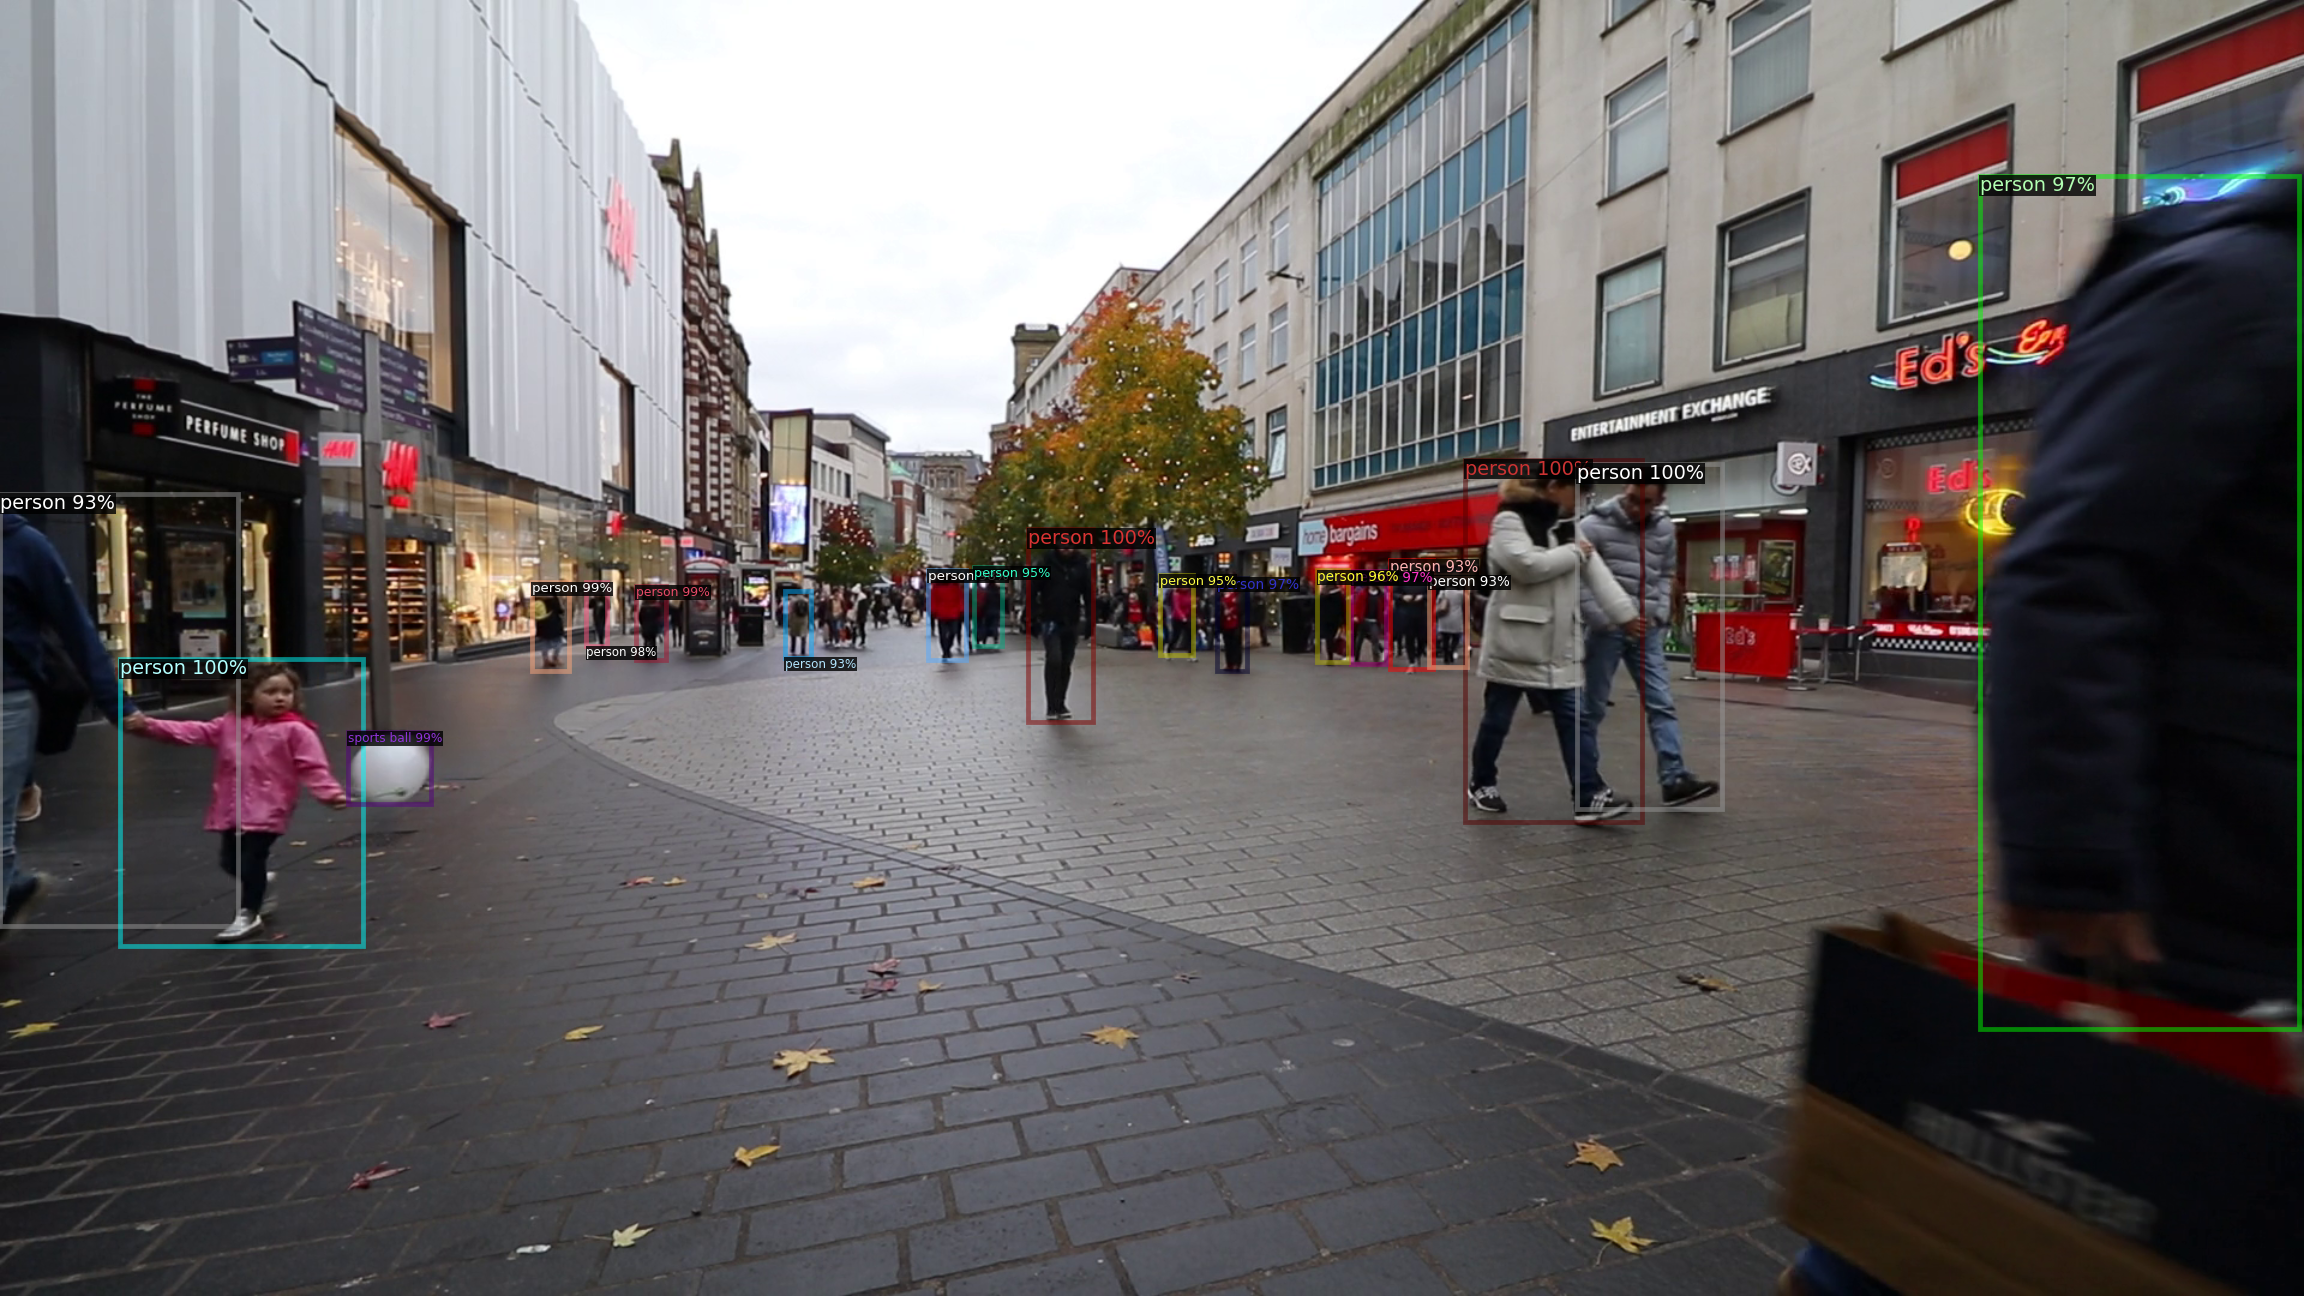

In [10]:
# Use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale = 1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# show predicted output
cv2_imshow(v.get_image()[:, :, ::-1])

In [11]:
# Outputs
# Objects present in image
classes = outputs['instances'].pred_classes.cpu().numpy()
print(classes)

[ 0  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [12]:
# bounding boxed of an object
bbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[[1220.5886    383.6059   1368.4237    685.6953  ]
 [ 856.7464    441.5567    910.5832    601.8466  ]
 [  99.950264  550.0594    302.16147   788.2948  ]
 [1314.3604    387.22845  1435.3945    674.4931  ]
 [ 443.2945    485.95612   474.5309    559.7267  ]
 [ 289.66144   610.53613   358.81323   670.02155 ]
 [ 530.0443    489.00854   554.73724   550.64374 ]
 [ 488.6168    485.21643   506.24414   539.195   ]
 [ 773.1828    475.2994    804.61194   550.5257  ]
 [1649.7915    147.69383  1915.5773    857.8394  ]
 [1126.1512    476.62582  1155.2935    554.2062  ]
 [1014.5485    481.9526   1039.1038    559.8485  ]
 [1097.6577    475.86435  1123.5968    552.34894 ]
 [ 811.6947    472.7364    835.3653    539.1096  ]
 [ 966.2469    479.49777   993.9183    546.31946 ]
 [   0.        412.21448   198.1461    771.93445 ]
 [1158.2352    467.2586   1193.759     557.91675 ]
 [ 653.9239    493.07986   675.5403    548.5164  ]
 [1190.9596    480.12204  1222.7839    555.92346 ]]


In [14]:
# identify only required classes and bounding boxes
# identity only persons 
ind = np.where(classes==0)[0]

# identify bounding box of only persons
person = bbox[ind]

# calculate total no. of persons
num = len(person)

In [15]:
# format of bounding box
x1, y1, x2, y2 = person[0]
print(x1, y1, x2, y2)

1220.5886 383.6059 1368.4237 685.6953


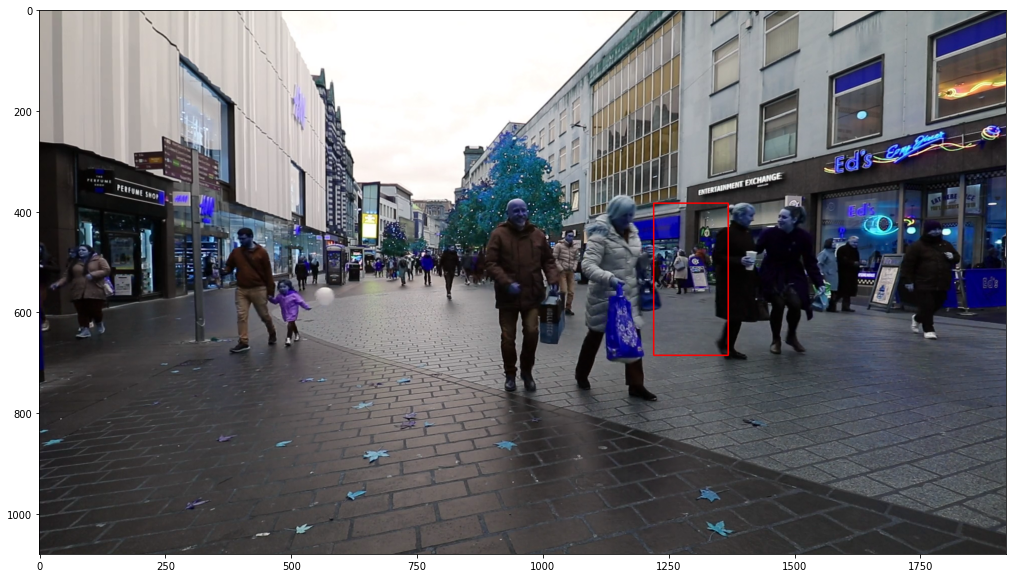

In [16]:
# Draw bounding box for one person
img = cv2.imread('frames/30.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.figure(figsize = (20,10))
# show plot
plt.imshow(img)

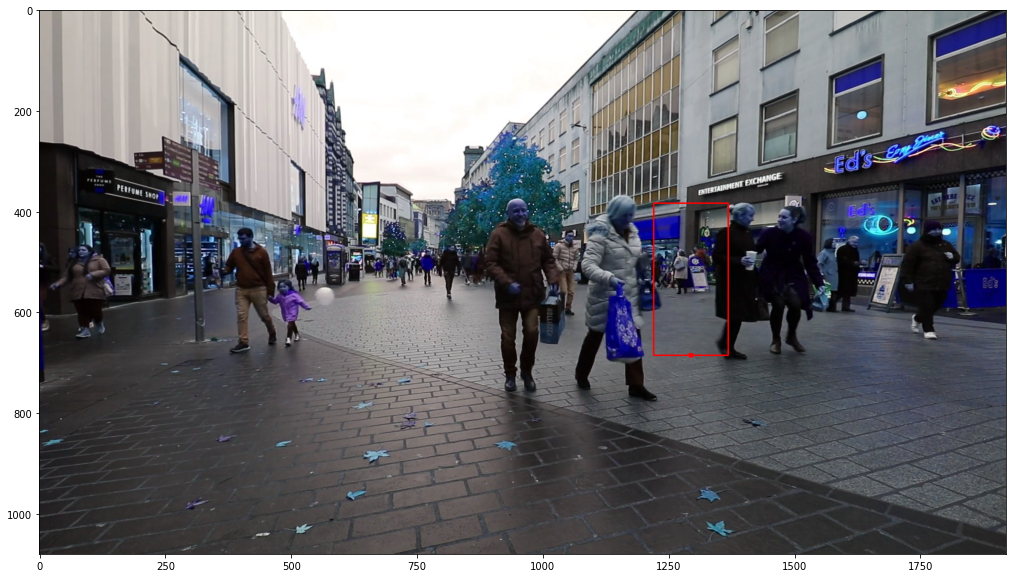

In [17]:
# set paramenters for computing the distance between two people
# compute center 
#  Using bottom center of a rectangle for representing each person
x_center = int((x1+x2)/2)
y_center = int(y2)

center = (x_center, y_center)

_ = cv2.circle(img, center, 5, (255, 0, 0), -1)
plt.figure(figsize=(20,10))
plt.imshow(img)

In [18]:
#define a function which return the bottom center of every bbox
def mid_point(img, person, idx):
  #get the coordinates
  x1,y1,x2,y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)
  
  #compute bottom center of bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 5, (0, 0, 255), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
  
  return mid

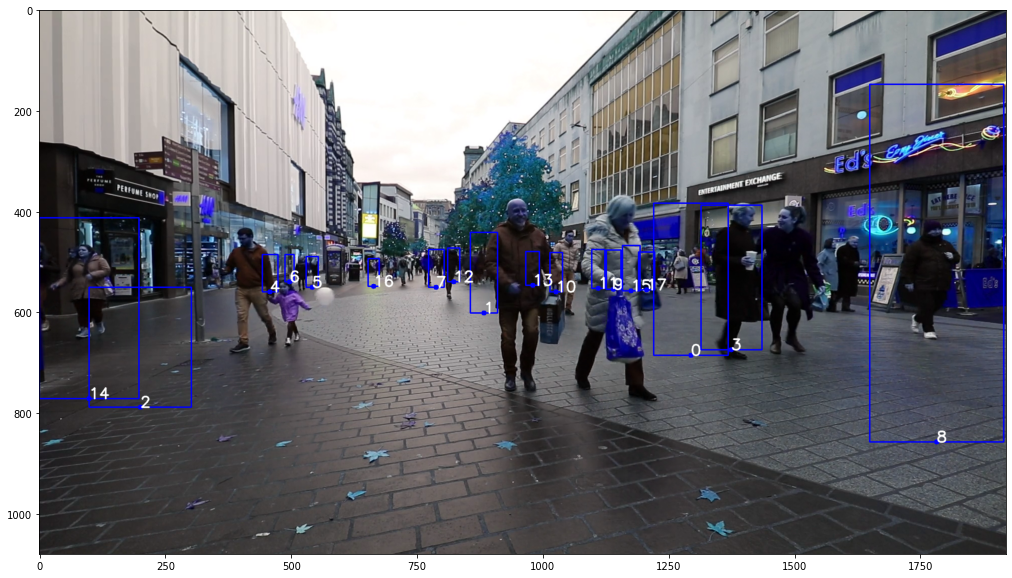

In [19]:
# Compute bottom center for every bounding box and draw the points on the image
# call the function
midpoints = [mid_point(img,person,i) for i in range(len(person))]

# visualize image
plt.figure(figsize=(20, 10))
# show image
plt.imshow(img)

In [20]:
# define function to compute the Euclidean distance between every two points in image
%%time
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j] = dst
  return dist

CPU times: user 51.5 ms, sys: 4.99 ms, total: 56.5 ms
Wall time: 59.4 ms


In [25]:
# Compute distance between every pair of points
dist = compute_distance(midpoints, num)

In [26]:
# Define a function to returns the closest people based on  given proximity distance
%%time
def find_closest(dist,num,thresh):
  p1 = []
  p2 = []
  d = []
  for i in range(num):
    for j in range(i, num):
      if( (i!=j) & (dist[i][j] <= thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1, p2, d

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.3 µs


In [27]:
# Set the threshold for the proximity distance
import pandas as pd

thresh = 100
p1, p2, d = find_closest(dist, num, thresh)
df = pd.DataFrame({"p1":p1, "p2":p2, "dist":d})
df

p1  p2       dist
0    0   3  80.752709
1    1  12  86.278618
2    4   5  84.480767
3    4   6  43.829214
4    5   6  46.324939
5    7  12  36.687873
6    9  11  30.066593
7    9  15  35.128336
8    9  17  66.007575
9   10  11  84.291162
10  10  13  47.801674
11  11  15  65.192024
12  11  17  96.046864
13  15  17  31.064449

In [28]:
# Define a function to change the color of the closest people to red
def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)  
  return img

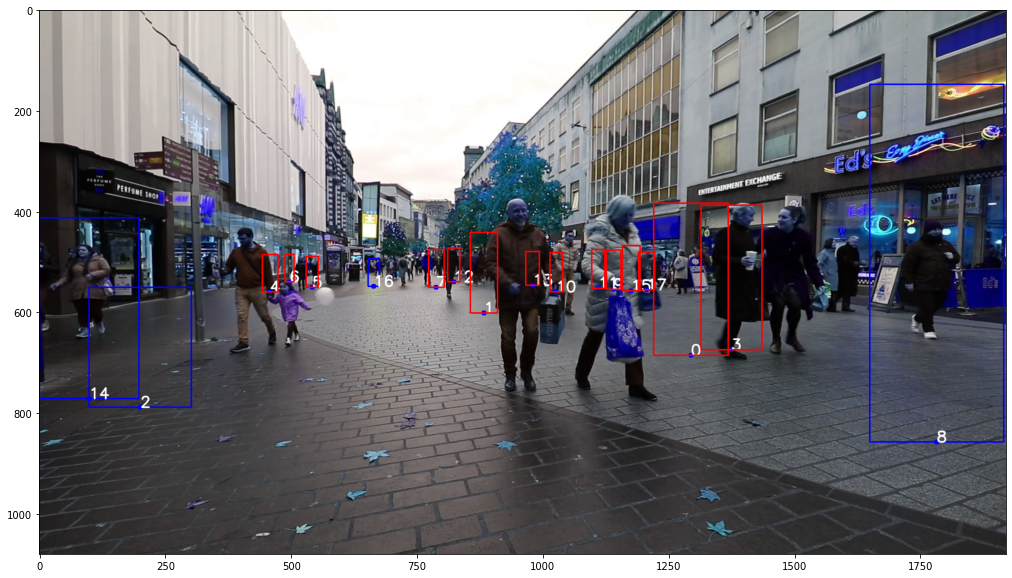

In [29]:
# change the color of the closest people to red
# call function
img = change_2_red(img,person,p1,p2)

plt.figure(figsize=(20,10))
plt.imshow(img)

In [31]:
# Repeating above steps on each and every frame of the video
import os
import re

names=os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

In [32]:
# Define a function that performs all the steps we covered on each and every frame of the video

def find_closest_people(name,thresh):

  img = cv2.imread('frames/'+name)
  outputs = predictor(img)
  classes = outputs['instances'].pred_classes.cpu().numpy()
  bbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
  ind = np.where(classes==0)[0]
  person = bbox[ind]
  midpoints = [mid_point(img, person, i) for i in range(len(person))]
  num = len(midpoints)
  dist = compute_distance(midpoints,num)
  p1, p2, d = find_closest(dist, num, thresh)
  img = change_2_red(img, person, p1, p2)
  cv2.imwrite('frames/'+name, img)
  return 0

In [33]:
# Identify the closest people in each frame and change color to red
from tqdm import tqdm
thresh=100
_ = [find_closest_people(names[i],thresh) for i in tqdm(range(len(names))) ]

100%|██████████| 750/750 [08:51<00:00,  1.41it/s]


In [34]:
# convert the frames back to a video.
%%time
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    
    #reading each files
    img = cv2.imread('frames/'+frames[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('sample_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

CPU times: user 49.1 s, sys: 3.97 s, total: 53.1 s
Wall time: 52.1 s
